In [1]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate,ParameterVector
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from typing import Iterable, Optional
from scipy.optimize import minimize

In [2]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
                # iterate through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(
                        Operator(twirl_gate) @ pauli_right
                    ):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(
            gate.base_class for gate in self.gates_to_twirl
        )
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pauli_index = np.random.randint(
                0, len(self.twirl_set[node.op.name])
            )
            twirl_pair = self.twirl_set[node.op.name][pauli_index]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(
                twirl_pair[0].to_instruction(), [register[0], register[1]]
            )
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(
                twirl_pair[1].to_instruction(), [register[0], register[1]]
            )
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [3]:
def qiskit_circular_ansatz(N, reps=1): 
    qc = QuantumCircuit(N)

    # define your parameters
    p = ParameterVector('p', (N*2) *(reps+1)) 

    for r in range(reps): 
        for i in range(N):
            qc.ry(p[2*N*r+i], i)  
        for i in range(N):
            qc.rz(p[2*N*r+(i+N)], i)
        for i in range(N):
            control = (i-1) % N
            target = i
            qc.cx(control, target)
    for i in range(N):
        qc.ry(p[2*N*reps+i], i)
    for i in range(N):
        qc.rz(p[2*N*reps + (i+N)], i)
    return qc

num_qubits = 4
qc = qiskit_circular_ansatz(num_qubits,reps=1)

In [4]:
np.random.seed(0)
paulis = ["".join(np.random.choice(['I', 'X', 'Y', 'Z'], size=num_qubits)) for _ in range(num_qubits)]
coeffs = np.random.random(len(paulis))
hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))

In [5]:
np.random.seed(0)
# Set initial parameters
initial_params = np.zeros(qc.num_parameters)
initial_params

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
# Calculate Exact Ground State Energy
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
ref_result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
ref_value = ref_result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.87300


In [11]:
# Create your custom pass
pm = PassManager([PauliTwirl()])

# Generate a preset pass manager
backend = FakeMumbaiV2() # Your quantum backend
# noise_model = NoiseModel.from_backend(backend)
noise_model = NoiseModel()
iteration_number = 0
print(noise_model)

NoiseModel: Ideal


In [12]:

from qiskit.quantum_info import Operator
from qiskit_aer.noise import QuantumError, NoiseModel,coherent_unitary_error

# Define the over-rotation angle (in radians)
theta = 0.1  # Adjust this value to control the amount of over-rotation

# Create the over-rotated CX gate
cx_overrotated = Operator([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
]) @ Operator([
    [np.cos(theta/2), -1j*np.sin(theta/2), 0, 0],
    [-1j*np.sin(theta/2), np.cos(theta/2), 0, 0],
    [0, 0, np.cos(theta/2), -1j*np.sin(theta/2)],
    [0, 0, -1j*np.sin(theta/2), np.cos(theta/2)]
])

# Create a quantum error from the over-rotated CX gate
error_cx = Operator(cx_overrotated)
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(error_cx), ['cx'])
print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [9]:
pt_vqe_energies=[]

def pt_vqe_cost_function(params, ansatz, hamiltonian, pass_manager, estimator):
    global iteration_number 
    # Bind parameters to the ansatz
    bound_circuit = ansatz.assign_parameters(params)
    
    #Apply the pass manager
    twirled_qcs = [pass_manager.run(bound_circuit) for _ in range(100)]

    # Calculate expectation value
    energy_values = np.array([])
    for transpiled_circuit in twirled_qcs:
        job = estimator.run([(transpiled_circuit, hamiltonian)]) #Something wrong w parameter optim.
        result = job.result()
        energy = result[0].data.evs #NOTE: Is this actually expectation value?
        energy_values = np.append(energy_values, energy)
    
    iteration_number += 1
    # Print statement to see where we are at
    print(f"Iteration: {iteration_number}, Current energy: {np.average(energy_values)}, Current parameters: {params}")
    # return result.values[0]
    pt_vqe_energies.append(np.average(energy_values))

    return np.average(energy_values)

# # Create an Estimator instance

##Noisy
estimator = Estimator(
    mode=AerSimulator(
        noise_model=noise_model,
        coupling_map=backend.coupling_map,
        basis_gates=noise_model.basis_gates,
        device = 'GPU'
    )
)

# # # Create an Estimator instance

# estimator = Estimator(mode=AerSimulator(method='statevector',device = "GPU"))

In [10]:
result = minimize(
    pt_vqe_cost_function,
    initial_params,
    args=(qc, hamiltonian, pm, estimator),
    method='COBYLA',
    options={'maxiter': 100}
)

pt_optimal_params = result.x
pt_optimal_value = result.fun

print(f"Optimal value: {pt_optimal_value}")
print(f"Optimal parameters: {pt_optimal_params}")

KeyboardInterrupt: 

In [23]:
iteration_number= 0

vqe_energies = []
def vqe_cost_function(params, ansatz, hamiltonian, pass_manager, estimator):
    global iteration_number 
    # Bind parameters to the ansatz
    bound_circuit = ansatz.assign_parameters(params)
    
    # Calculate expectation value
    job = estimator.run([(bound_circuit, hamiltonian)]) #Something wrong w parameter optim.
    result = job.result()
    energy = result[0].data.evs #NOTE: Is this actually expectation value?
    vqe_energies.append(energy)
    
    iteration_number += 1
    # Print statement to see where we are at
    print(f"Iteration: {iteration_number}, Current energy: {energy}, Current parameters: {params}")
    return energy

In [24]:
new_params = np.random.random(qc.num_parameters)
result = minimize(
    vqe_cost_function,
    new_params,
    args=(qc, hamiltonian, pm, estimator),
    method='COBYLA',
    options={'maxiter': 1000}
)

optimal_params = result.x
optimal_value = result.fun

print(f"Optimal value without PT : {optimal_value}")
print(f"Optimal parameters: {optimal_params}")

Iteration: 1, Current energy: 0.02420055285826027, Current parameters: [0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606 0.0871293 ]
Iteration: 2, Current energy: 0.11344809091640538, Current parameters: [1.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606 0.0871293 ]
Iteration: 3, Current energy: 0.008915457398063695, Current parameters: [0.5488135  1.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606 0.0871293 ]
Iteration: 4, Current energy: -0.4056334723844335, Current parameters: [0.5488135  1.71518937 1.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606 0.08712

In [25]:
print(f"Exact Ground State: {ref_value}")

Exact Ground State: -1.8730038862523393


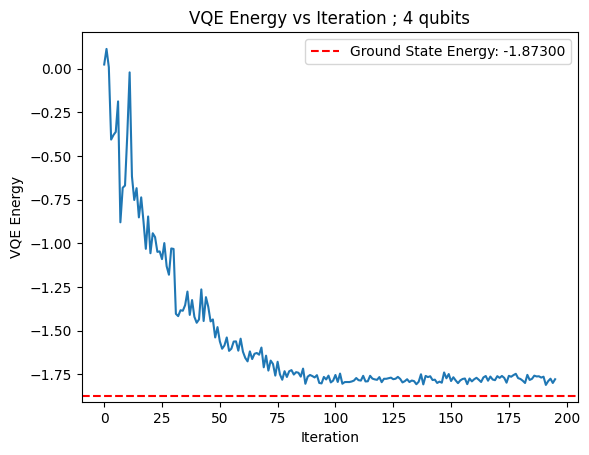

In [26]:
import matplotlib.pyplot as plt

plt.plot(vqe_energies)
plt.plot(pt_vqe_energies)
plt.axhline(y=ref_value, color='r', linestyle='--', label=f'Ground State Energy: {ref_value:.5f}')
plt.xlabel('Iteration')
plt.ylabel('VQE Energy')
plt.title(f'VQE Energy vs Iteration ; {num_qubits} qubits')
plt.legend()
plt.show()